In [1]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image

# Choose variants here:

In [2]:
trained_model = False
arch = 'ResNet18'

## System setup:

In [3]:
import inversefed
setup = inversefed.utils.system_startup()
defs = inversefed.training_strategy('conservative')

loss_fn, trainloader, validloader =  inversefed.construct_dataloaders('ImageNet', defs, 
                                                                      data_path='/mnt/ssd4/weiyang/Dataset/')

model = torchvision.models.resnet18(pretrained=trained_model)
model.to(**setup)
model.eval();

Currently evaluating -------------------------------:
Friday, 18. February 2022 03:04PM
CPUs: 24, GPUs: 2 on chfa01-desktop.
GPU : NVIDIA GeForce RTX 3090


In [4]:
dm = torch.as_tensor(inversefed.consts.imagenet_mean, **setup)[:, None, None]
ds = torch.as_tensor(inversefed.consts.imagenet_std, **setup)[:, None, None]
def plot(tensor):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu());
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2, 0).cpu());

# Reconstruct

### Build the input (ground-truth) gradient

[('tench', 'Tinca tinca')]


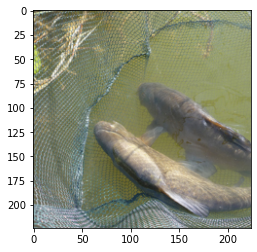

In [5]:
idx = 0
# 8112 # the beagle
# 1200 # the owl
# 11794 # the German shepherd
# 19449 # the panda


# np.random.randint(len(validloader.dataset))

img, label = validloader.dataset[idx]
labels = torch.as_tensor((label,), device=setup['device'])
ground_truth = img.to(**setup).unsqueeze(0)
plot(ground_truth);
print([trainloader.dataset.classes[l] for l in labels]);

In [ ]:
ground_truth_denormalized = torch.clamp(ground_truth * ds + dm, 0, 1)
torchvision.utils.save_image(ground_truth_denormalized, f'{idx}_{arch}_ImageNet_input.png')

In [6]:
model.zero_grad()
target_loss, _, _ = loss_fn(model(ground_truth), labels)
input_gradient = torch.autograd.grad(target_loss, model.parameters())
input_gradient = [grad.detach() for grad in input_gradient]
full_norm = torch.stack([g.norm() for g in input_gradient]).mean()
print(f'Full gradient norm is {full_norm:e}.')

Full gradient norm is 2.217701e+00.


It: 0. Rec. loss: 0.0556.
It: 500. Rec. loss: 0.0323.
It: 1000. Rec. loss: 0.0230.
It: 1500. Rec. loss: 0.0199.
It: 2000. Rec. loss: 0.0194.
It: 2500. Rec. loss: 0.0190.
It: 3000. Rec. loss: 0.0168.
It: 3500. Rec. loss: 0.0182.
It: 4000. Rec. loss: 0.0196.
It: 4500. Rec. loss: 0.0194.
It: 5000. Rec. loss: 0.0192.
It: 5500. Rec. loss: 0.0183.
It: 6000. Rec. loss: 0.0174.
It: 6500. Rec. loss: 0.0180.
It: 7000. Rec. loss: 0.0174.
It: 7500. Rec. loss: 0.0175.
It: 8000. Rec. loss: 0.0173.
It: 8500. Rec. loss: 0.0176.
It: 9000. Rec. loss: 0.0187.
It: 9500. Rec. loss: 0.0102.
It: 10000. Rec. loss: 0.0089.
It: 10500. Rec. loss: 0.0088.
It: 11000. Rec. loss: 0.0082.
It: 11500. Rec. loss: 0.0074.
It: 12000. Rec. loss: 0.0080.
It: 12500. Rec. loss: 0.0073.
It: 13000. Rec. loss: 0.0074.
It: 13500. Rec. loss: 0.0073.
It: 14000. Rec. loss: 0.0074.
It: 14500. Rec. loss: 0.0072.
It: 15000. Rec. loss: 0.0069.
It: 15500. Rec. loss: 0.0064.
It: 16000. Rec. loss: 0.0058.
It: 16500. Rec. loss: 0.0058.
It: 

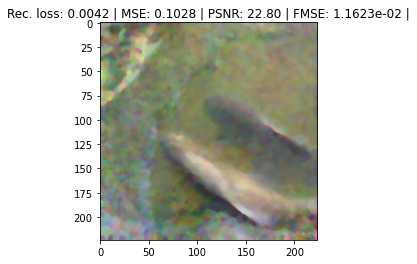

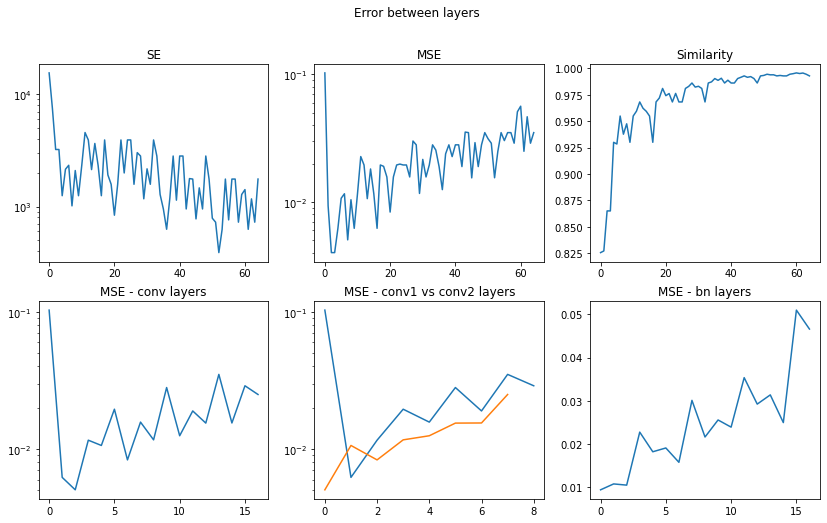

In [7]:
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='top10',
              weights='equal',
              lr=0.1,
              optim='adam',
              restarts=3,
              max_iterations=24_000,
              total_variation=1e-6,
              init='randn',
              filter='median',
              lr_decay=True,
              scoring_choice='loss')

rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=1)
output, stats = rec_machine.reconstruct(input_gradient, labels, img_shape=(3, 224, 224))

test_mse = (output.detach() - ground_truth).pow(2).mean()
feat_mse = (model(output.detach())- model(ground_truth)).pow(2).mean()  
test_psnr = inversefed.metrics.psnr(output, ground_truth, factor=1/ds)

plot(output)
plt.title(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} "
          f"| PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |");

data = inversefed.metrics.activation_errors(model, output, ground_truth)

fig, axes = plt.subplots(2, 3, sharey=False, figsize=(14,8))
axes[0, 0].semilogy(list(data['se'].values())[:-3])
axes[0, 0].set_title('SE')
axes[0, 1].semilogy(list(data['mse'].values())[:-3])
axes[0, 1].set_title('MSE')
axes[0, 2].plot(list(data['sim'].values())[:-3])
axes[0, 2].set_title('Similarity')

convs = [val for key, val in data['mse'].items() if 'conv' in key]
axes[1, 0].semilogy(convs)
axes[1, 0].set_title('MSE - conv layers')
convs = [val for key, val in data['mse'].items() if 'conv1' in key]
axes[1, 1].semilogy(convs)
convs = [val for key, val in data['mse'].items() if 'conv2' in key]
axes[1, 1].semilogy(convs)
axes[1, 1].set_title('MSE - conv1 vs conv2 layers')
bns = [val for key, val in data['mse'].items() if 'bn' in key]
axes[1, 2].plot(bns)
axes[1, 2].set_title('MSE - bn layers')
fig.suptitle('Error between layers');

In [9]:
output_denormalized = torch.clamp(output * ds + dm, 0, 1)
torchvision.utils.save_image(output_denormalized, f'{idx}_{arch}_untrained_output.png')